# Encoder-Decoder architectures (U-Net)

## Introduction: Semantic segmentation

What do medical imaging, autonomous cars and satellite imagery have in common? In each of these fields, you need to be able to detect distinct objects with great precision. Perfect, you already know an arsenal of deep-learning techniques for object detection. However, here we need something more precise than simple coarse detection, namely to know contours with a high degree of accuracy, whether it's counting cells, not mistaking a pedestrian for a lamppost or detecting undeclared private swimming pools [[1]].

[1]: https://www.numerama.com/tech/1410142-le-fisc-a-debusque-120-000-piscines-non-declarees-avec-lintelligence-artificielle.html

| <img src="img/cells_detection.jpg" alt="Image 1" width="600"/> | <img src="img/Tesla-Autopilot.jpg" alt="Image 2" width="600"/> | <img src="img/Satelite_image.png" alt="Image 3" width="600"/> |
|:--:|:--:|:--:|
| [Image 1 Source](https://www.semanticscholar.org/paper/Cell-Segmentation-by-Combining-Marker-Controlled-Lux-Matula/5d61a6af14d1d66c121f99843a03de6cd45ac51e) | [Image 2 Source](https://www.teslarati.com/tesla-3d-labeling-autopilot-reliability-big-leap/) | [Image 3 Source](https://www.semanticscholar.org/paper/Satellite-Image-Semantic-Segmentation-Using-Fully-Yoshihara-Hascoet/9e31c11b678e4ba0cbb8cb96094a68e4969fb8b8/figure/1)

They employ a common technique known as image segmentation, which is a computer vision method that automatically divides an image into regions of pixels associated with the same object class. Image segmentation manifests in two primary forms: semantic segmentation and instance segmentation. Semantic segmentation involves classifying image pixels as either belonging or not belonging to a specific category. Conversely, instance segmentation provides more detailed information by delineating distinct instances of the same object, such as identifying multiple cats in one image instead of a single 'blob' labeled 'cats'. If one desires to perform both types of segmentation simultaneously, as seen in autonomous driving applications where the road is identified as one 'blob' (semantic segmentation) and each pedestrian is individually outlined (instance segmentation), the combined use of both techniques is referred to as [panoptic segmentation](https://paperswithcode.com/task/panoptic-segmentation). This entails employing both methods concurrently on different parts of the image.

<div style="text-align:center;">
  <img src="img/instant_vs_semantic.png" alt="Image 1" width="400"/>

  [Image 1 Source](https://larevueia.fr/quest-ce-que-la-segmentation-dimages/)
</div>

<details class="alert alert-warning">
    <summary markdown="span"><b>Click to reveal hidden text</b></summary>
    If you've been paying attention, yes, the image of what the autonomous car sees is not a good representation of image segmentation; <br> 
    it's a simple object detection since the contours are coarse. More details <a href="https://www.picsellia.com/post/segmentation-vs-detection-vs-classification-in-computer-vision-a-comparative-analysis" target="_blank">here</a>.
</details>


So how do you go about it? Well, there are a number of techniques available, and it doesn't necessarily have to be deep-learning. We're going to look at medical images, because they're often difficult to analyze correctly, and I'm going to start by giving you a simple task: can you count the number of bacteria in this image?

<div style="text-align:center;">
  <img src="img/bacteria.png" alt="Image 1" width="400"/>

  [Image 1 Source](https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.fbioyf.unr.edu.ar%2Fevirtual%2Fmod%2Fresource%2Fview.php%3Fid%3D6917&psig=AOvVaw0hPUnk2E44hUssIgVC6Ohi&ust=1705932070552000&source=images&cd=vfe&opi=89978449&ved=0CBQQjhxqFwoTCKjVkubR7oMDFQAAAAAdAAAAABAJ)
</div>

<details class="alert alert-warning">
    <summary markdown="span"><b>Answer</b></summary>
    53
</details>


Your eyes and brain are fantastic tools for quickly isolating structures. But how do you get a computer to do the job? First, you need to read the image and reduce it to two dimensions

In [3]:
import matplotlib.pyplot as plt
import numpy as np

COLORS = {'BLUE': '#3D6FFF',
          'RED': '#FF3D3D',
          'ORANGE': '#FF8E35',
          'PURPLE': '#BB58FF',
          'GREEN': '#32CD32',
          'YELLOW': '#F9DB00',
          'PINK': '#FFC0CB',
          'BROWN': '#8B4513',
          'CYAN': '#00FFFF',
}

image = plt.imread('img/bacteria.png')
shape_before = image.shape
image = image[:,:,0]

print(f"Shape before: {shape_before}")
print(f"Shape after:  {image.shape}")

Shape before: (507, 537, 3)
Shape after:  (507, 537)


It's important to understand that, in this image, what makes it possible to distinguish the bacteria from the background is the high contrast between them (in fact, there are "three groups" of colors in this image, black representing the bacteria, gray and white representing the background). Can these pixel groups be visualized in a histogram?

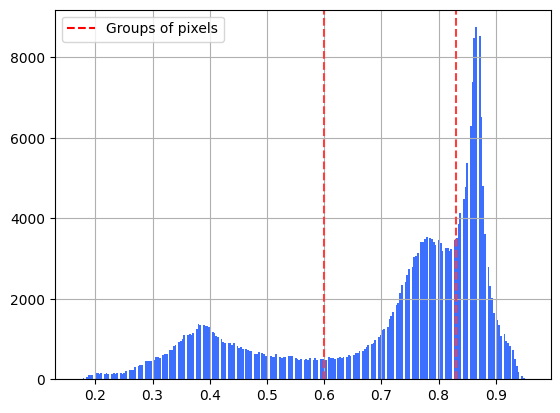

In [4]:
image_2 = np.copy(image)

plt.hist(image_2.ravel(), bins=255, color=COLORS['BLUE'])

plt.axvline(x=0.6, linestyle='--', color=COLORS['RED'])
plt.axvline(x=0.83, linestyle='--', color=COLORS['RED'])

red_legend = plt.Line2D([0], [0], color='red', linestyle='--', label='Groups of pixels')
plt.legend(handles=[red_legend])

plt.grid()  
plt.show()

The first group below 0.6 represents black pixels and therefore bacteria, the group between 0.6 and 0.83 grey pixels and above 0.83 white pixels. So how to easily extract bacteria in the image?

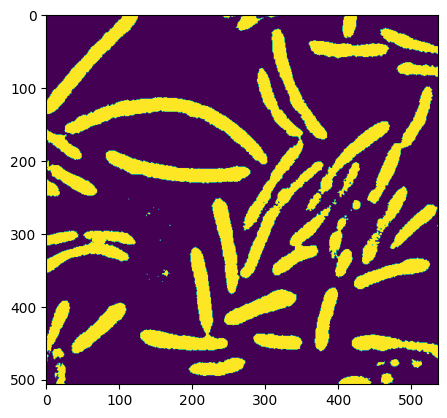

In [20]:
bacteria = image < 0.6
plt.imshow(bacteria)

Not bad at all! The bacteria are clearly visible, but there are still a few artifacts. We could stop there, but we can use the module scipy and more precisely the submodule [scipy.ndimage](https://docs.scipy.org/doc/scipy/reference/ndimage.html) to remove them (scipy.ndimage is a library that provides a collection of functions for multidimensional image processing. It is particularly useful for tasks such as image filtering, interpolation, morphology, measurements and in our case smooth out the contours removing artifacts). 

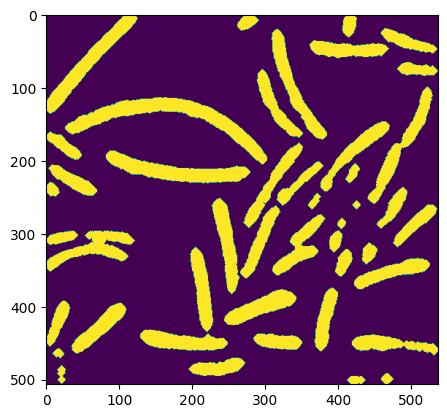

In [21]:
import scipy.ndimage as ndi

bacteria = ndi.binary_opening(bacteria, iterations=5)

plt.imshow(bacteria)

<details class="alert alert-warning">
    <summary markdown="span"><b>Click to have more info about binary_opening</b></summary>
    <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.binary_opening.html" target="_blank">scipy.ndimage.binary_opening</a> is a function provided by the SciPy library in the ndimage module. This function is designed for binary image processing, specifically for morphological operations. Morphological operations involve the manipulation of the structure of an image, usually through the use of binary masks or structuring elements; it is commonly used to remove small objects and smooth the boundaries of larger objects in a binary image.
    <br><br> 
    <div style="display: flex; justify-content: space-between">
        <!-- Erosion Section -->
        <div style="flex: 1; text-align: center;">
            <h3>Erosion</h3>
            <p>The function first performs an <b>erosion</b> on the image that shrinks or erodes the boundaries of foreground objects (white regions) in a binary image. The basic idea is to slide a structuring element (also binary) over the input image, and for each position of the structuring element, if all the pixels underneath it are white (1), the corresponding pixel in the output image remains white; otherwise, it becomes black (0)</p>
            <img src="img/erosion.gif" alt="Erosion GIF" width="400"/>
            <p style="text-align: center;"><a href="https://pub.towardsai.net/introduction-to-image-processing-with-python-b3a85fd26734">Erosion</a></p>
        </div>
        <!-- Dilatation Section -->
        <div style="flex: 1; text-align: center;">
            <h3>Dilatation</h3>
            <p>The function then performs a <b>dilatation</b>, it expands or dilates the boundaries of foreground objects in a binary image. Similar to erosion, a structuring element is used, and for each position of the structuring element, if at least one pixel underneath it is white, the corresponding pixel in the output image becomes white; otherwise, it remains black.</p>
            <img src="img/dilatation.gif" alt="Dilatation GIF" width="400"/>
            <p style="text-align: center;"><a href="https://pub.towardsai.net/introduction-to-image-processing-with-python-b3a85fd26734">Dilatation</a></p>
        </div>
    </div>
    <br><br> 
</details>

||This is a spoiler!||


![Image Alt Text](img/U_net_visualization.png)

Source: [Image Source](https://arxiv.org/pdf/1505.04597.pdf)

https://arxiv.org/pdf/1505.04597.pdf
https://datascientest.com/u-net
https://larevueia.fr/quest-ce-que-la-segmentation-dimages/
https://www.superannotate.com/blog/guide-to-semantic-segmentation
https://blent.ai/blog/a/unet-computer-vision

https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.binary_opening.html